In [22]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from sphere_initialization import generate_class_vectors
from sphere_initialization import generate_class_vectors_hemispheres
from siglip_loss import SigLIPLoss
from siglip_experiment import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Without Explicit Adapter

In [87]:
torch.manual_seed(50)

n_classes = 20
dim = 4
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'


initial_temperature = 10.0
initial_relative_bias = 0
initial_x= 0.5

delta = torch.sigmoid(torch.tensor(initial_x)).item()
initial_temperature_rescaled = initial_temperature * delta 
initial_relative_bias_rescaled = initial_relative_bias + (1 - delta**2)  

bias_is_trainable = True
temperature_is_trainable = True
U0 = torch.randn(n_classes, dim, device = device_str)
U0np = U0.cpu().detach().numpy()
U0np= U0np/np.linalg.norm(U0np, axis = 1, keepdims = True)
print(U0np[:5,:5])
print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str,
    when_to_print = 100
)

U_final, V_final, criterion_final, no_adapter_losses_history = experiment.train(
    relative_bias=initial_relative_bias_rescaled,
    temperature=initial_temperature_rescaled,
    trainable_bias=bias_is_trainable,
    trainable_temp=temperature_is_trainable,
    fixed_U=U0,
    explicit_adapter=False
    )

print("\n--- Training Complete ---")
print(f"Final Loss: {no_adapter_losses_history[-1]:.4f}")
print(f"Final Temperature: {criterion_final.get_temperature():.4f}")
print(f"Final Bias Value: {criterion_final.get_bias():.4f}")

[[-0.8114052   0.2572127   0.49784163 -0.16618326]
 [-0.54780436  0.30176476 -0.47503573 -0.619023  ]
 [-0.72861284 -0.08216877  0.6621892   0.15452209]
 [ 0.01379845 -0.00634132 -0.9714164  -0.23689547]
 [ 0.08150048 -0.53878915  0.75956386 -0.35514325]]
Using device: cpu
Running experiment with: n_classes=20, dim=4, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0, trainable_bias=True
[100/10000]  loss=0.0942  T=4.9346  rb=1.0102
[200/10000]  loss=0.0348  T=9.6514  rb=0.8865
[300/10000]  loss=0.0096  T=18.3973  rb=0.8226
[400/10000]  loss=0.0033  T=26.2162  rb=0.8108
[500/10000]  loss=0.0015  T=31.9971  rb=0.8058
[600/10000]  loss=0.0009  T=36.4707  rb=0.8037
[700/10000]  loss=0.0006  T=40.1314  rb=0.8030
[800/10000]  loss=0.0004  T=43.2458  rb=0.8029
[900/10000]  loss=0.0003  T=45.9689  rb=0.8031
[1000/10000]  loss=0.0002  T=48.3984  rb=0.8035
[1100/10000]  loss=0.0002  T=50.5990  rb=0.8040
[1200/10000]  loss=0.0001  T=52.6164  rb=0.8046
[1300/10000]  loss=0.0001  T=54.

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='2d')
experiment.plot_vectors(
        U_final,
        V_final,
        criterion_final,
        ax=ax
    )
ax.legend()
plt.show

In [ ]:
plt.plot()

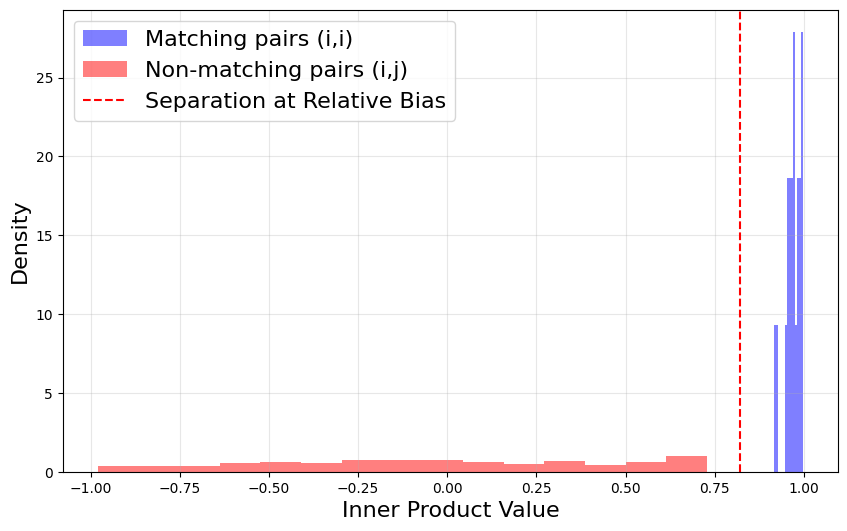

In [85]:
# Calculate all pairwise inner products
inner_products = torch.matmul(U_final, V_final.t())

# Get matching pairs (diagonal elements)
matching_pairs = torch.diag(inner_products).detach().cpu().numpy()

# Get non-matching pairs (off-diagonal elements)
mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
non_matching_pairs = inner_products[mask].detach().cpu().numpy()

# Create histogram plot
plt.figure(figsize=(10, 6))
plt.hist(matching_pairs, bins=15, alpha=0.5, label='Matching pairs (i,i)', color='blue', density=True)
plt.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i,j)', color='red', density=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(matching_pairs)
max_non_matching = np.max(non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='red', linestyle='--', label='Separation at Relative Bias')

plt.xlabel('Inner Product Value',fontsize=16)
plt.ylabel('Density',fontsize=16)
fig.suptitle('Inner Product Separation with Frozen Modality without Explicit Adapter', fontsize=20)
plt.legend(fontsize= 16)
plt.grid(True, alpha=0.3)
# plt.savefig('logs/frozen_modality_no_adapter_ip_separation.png',dpi =100,  bbox_inches='tight')
plt.show()


# Experiments with Explicit Adapter

In [88]:
print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str
)

U_final, V_final, criterion_final, with_adapter_losses_history, x_final = experiment.train(
    relative_bias=initial_relative_bias,
    temperature=initial_temperature,
    trainable_bias=bias_is_trainable,
    trainable_temp=temperature_is_trainable,
    fixed_U=U0,
    explicit_adapter=True,
    initial_x=0.5
)

print("\n--- Training Complete ---")
print(f"Final Loss: {with_adapter_losses_history[-1]:.4f}")
print(f"Final Temperature: {criterion_final.get_temperature():.4f}")
print(f"Final Delta: {torch.sigmoid(x_final).item():.4f}")
print(f"Final Bias Value: {criterion_final.get_bias():.4f}")

Using device: cpu
Running experiment with: n_classes=20, dim=4, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0, trainable_bias=True
[100/10000]  loss=0.1138  δ=0.6508  T=9.1182  rb=-0.1003
[200/10000]  loss=0.0279  δ=0.7625  T=19.6654  rb=0.0754
[300/10000]  loss=0.0049  δ=0.8177  T=35.4549  rb=0.2079
[400/10000]  loss=0.0017  δ=0.8351  T=45.5071  rb=0.2582
[500/10000]  loss=0.0008  δ=0.8438  T=52.3741  rb=0.2845
[600/10000]  loss=0.0005  δ=0.8492  T=57.6131  rb=0.3015
[700/10000]  loss=0.0003  δ=0.8531  T=61.8816  rb=0.3139
[800/10000]  loss=0.0002  δ=0.8561  T=65.5061  rb=0.3235
[900/10000]  loss=0.0002  δ=0.8585  T=68.6719  rb=0.3312
[1000/10000]  loss=0.0001  δ=0.8605  T=71.4941  rb=0.3378
[1100/10000]  loss=0.0001  δ=0.8622  T=74.0490  rb=0.3434
[1200/10000]  loss=0.0001  δ=0.8637  T=76.3900  rb=0.3483
[1300/10000]  loss=0.0001  δ=0.8650  T=78.5561  rb=0.3526
[1400/10000]  loss=0.0001  δ=0.8662  T=80.5761  rb=0.3566
[1500/10000]  loss=0.0001  δ=0.8673  T=82.4726  rb

<function matplotlib.pyplot.show(close=None, block=None)>

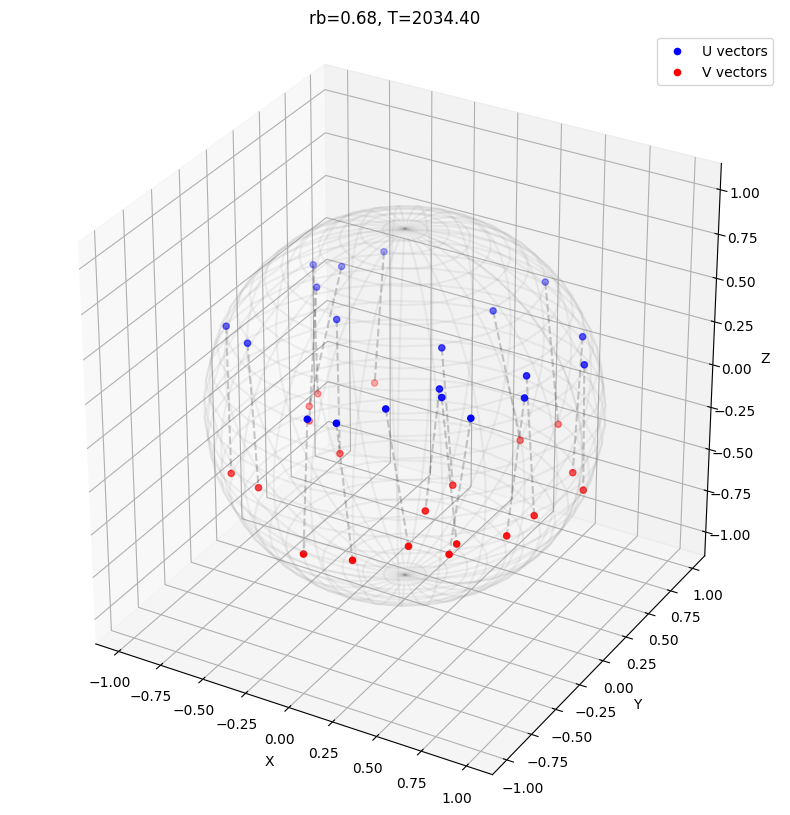

In [80]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
experiment.plot_vectors(
        U_final[:,1 :],
        V_final[:,1 :],
        criterion_final,
        ax=ax
    )
ax.legend()
plt.show

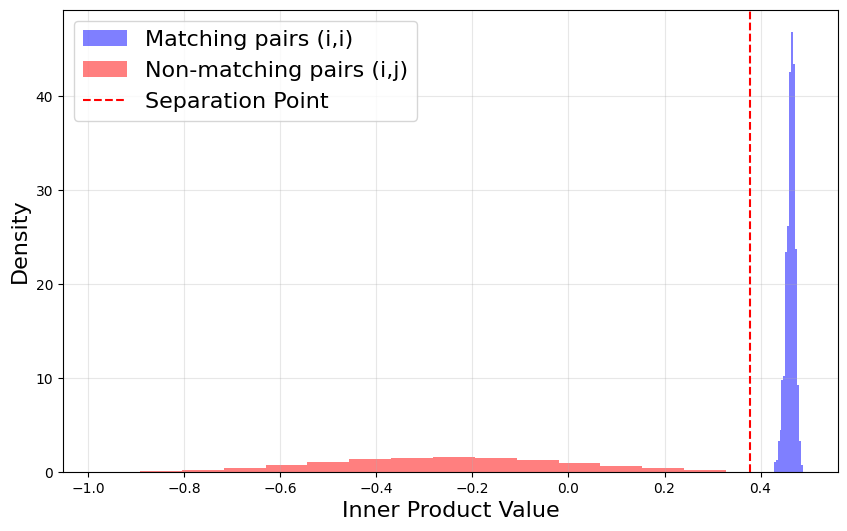

In [ ]:
# Calculate all pairwise inner products
inner_products = torch.matmul(U_final, V_final.t())

# Get matching pairs (diagonal elements)
matching_pairs = torch.diag(inner_products).detach().cpu().numpy()

# Get non-matching pairs (off-diagonal elements)
mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
non_matching_pairs = inner_products[mask].detach().cpu().numpy()

# Create histogram plot
plt.figure(figsize=(10, 6))
plt.hist(matching_pairs, bins=15, alpha=0.5, label='Matching pairs (i,i)', color='blue', density=True)
plt.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i,j)', color='red', density=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(matching_pairs)
max_non_matching = np.max(non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='red', linestyle='--', label='Separation Point')

plt.xlabel('Inner Product Value',fontsize=16)
plt.ylabel('Density',fontsize=16)
fig.suptitle('Inner Product Separation with Frozen Modality and Explicit Adapter', fontsize=20)
plt.legend(fontsize= 16)
plt.grid(True, alpha=0.3)
plt.savefig('logs/frozen_modality_with_adapter_ip_separation.png',dpi =300,  bbox_inches='tight')
plt.show()


# Comparison of Losses

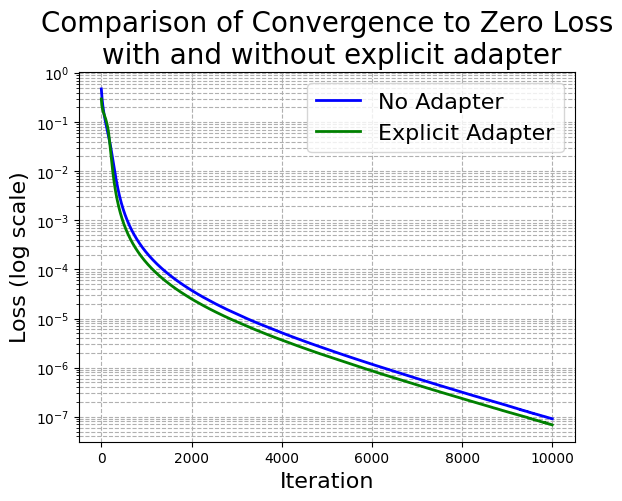

In [89]:
#plt.figure(figsize=(8, 6))
iters= np.arange(10000)
# Plot the two lines
plt.plot(iters, no_adapter_losses_history , label='No Adapter', linewidth=2,color = "blue")
plt.plot(iters, with_adapter_losses_history, label= 'Explicit Adapter', linewidth=2,color = "green")

# Set log scale on y-axis (or use plt.xscale("log") for x-axis)
plt.yscale('log')

# Add labels and title
plt.xlabel('Iteration', fontsize = 16)
plt.ylabel('Loss (log scale)', fontsize = 16)
plt.title('Comparison of Convergence to Zero Loss\n with and without explicit adapter', fontsize = 20)
plt.legend(fontsize = 16)
plt.grid(True, which='both', linestyle='--')

plt.savefig('logs/losscoparisonadaptervsno.png',dpi =300,  bbox_inches='tight')
# Show the plot
plt.show()

In [62]:
[np.log10(x) for x in no_adapter_losses_history]

[0.16862042650631728,
 0.14936723297387083,
 0.12999490213192383,
 0.11052359290485674,
 0.09097459542595014,
 0.07136883563896908,
 0.05172747747230283,
 0.03207157284745613,
 0.012421782963965709,
 -0.007201288509082114,
 -0.02677742620313067,
 -0.046287020237805496,
 -0.06571138896229956,
 -0.08503222451869379,
 -0.10423240451351565,
 -0.12329553607616787,
 -0.14220642163175407,
 -0.16095095955678107,
 -0.1795163449879907,
 -0.19789097875363332,
 -0.2160645467330113,
 -0.23402806502554024,
 -0.2517738834617725,
 -0.26929549543989845,
 -0.2865877062719567,
 -0.3036465984239333,
 -0.3204690725600215,
 -0.33705362771980896,
 -0.35339935063554095,
 -0.3695064591172823,
 -0.3853760543487483,
 -0.40100996621717006,
 -0.4164106268859606,
 -0.43158116232947985,
 -0.44652518208745584,
 -0.4612468279396914,
 -0.47575053192299427,
 -0.4900410538061664,
 -0.5041233747371299,
 -0.5180028815071972,
 -0.5316849405518674,
 -0.5451751280521129,
 -0.5584789600580667,
 -0.5716021652094048,
 -0.5845503

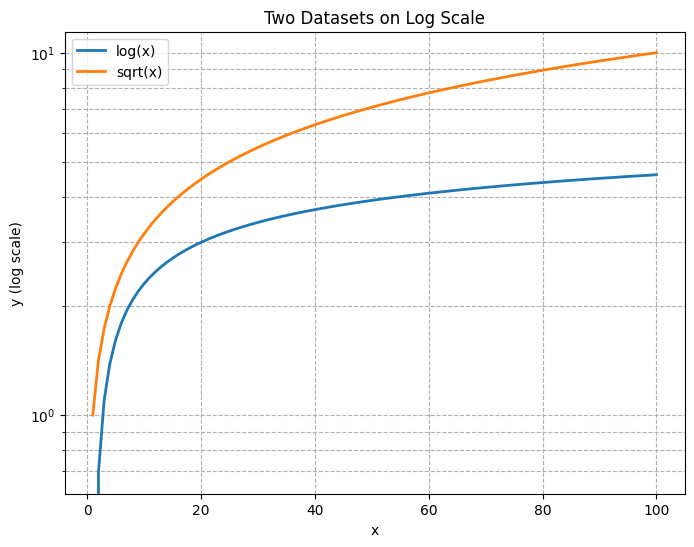

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Example datasets
x = np.linspace(1, 100, 100)  # X-values from 1 to 100 (must be > 0 for log scale)
y1 = np.log(x)                # First dataset
y2 = np.sqrt(x)               # Second dataset

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the two lines
plt.plot(x, y1, label='log(x)', linewidth=2)
plt.plot(x, y2, label='sqrt(x)', linewidth=2)

# Set log scale on y-axis (or use plt.xscale("log") for x-axis)
plt.yscale('log')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y (log scale)')
plt.title('Two Datasets on Log Scale')
plt.legend()
plt.grid(True, which='both', linestyle='--')

# Show the plot
plt.show()
